In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from tensorflow import keras as keras
from keras import optimizers
from keras.models import Sequential 
from keras.layers import Dense, Activation, Conv2D, Flatten, MaxPooling2D

from sklearn.model_selection import train_test_split

%matplotlib inline

In [194]:
training = pd.read_csv('../facial-keypoints-detection/training.csv')
test = pd.read_csv('../facial-keypoints-detection/test.csv')

In [3]:
training.shape

(7049, 31)

In [4]:
img0 = training.iloc[0,30]
img0

'238 236 237 238 240 240 239 241 241 243 240 239 231 212 190 173 148 122 104 92 79 73 74 73 73 74 81 74 60 64 75 86 93 102 100 105 109 114 121 127 132 134 137 137 140 139 138 137 137 140 141 143 144 147 148 149 147 147 148 145 147 144 146 147 147 143 134 130 130 128 116 104 98 90 82 78 85 88 86 80 77 87 108 111 115 128 133 188 242 252 250 248 251 250 250 250 235 238 236 238 238 237 238 242 241 239 237 233 215 195 187 156 119 103 93 78 68 73 75 75 72 75 70 61 66 77 91 96 106 108 113 120 125 131 134 138 135 138 139 145 144 144 142 140 141 141 148 147 150 149 152 151 149 150 147 148 144 148 144 146 146 143 139 128 132 135 128 112 104 97 87 78 79 83 85 83 75 75 89 109 111 117 117 130 194 243 251 249 250 249 250 251 237 236 237 238 237 238 241 238 238 238 241 221 195 187 163 124 106 95 81 68 70 73 73 72 73 69 65 74 82 94 103 110 111 119 127 135 140 139 144 144 145 143 143 143 146 144 144 147 146 148 147 150 146 147 150 150 149 147 147 144 147 144 149 146 144 144 144 140 131 133 133 125 110 

Note that the output is a single string - that means we will need to convert this to an array or list of ints before we can use the plt.imshow() command.

In [268]:
img0arr = np.array(img0.split())
a = img0arr.astype(int)
a

array([238, 236, 237, ...,  70,  75,  90])

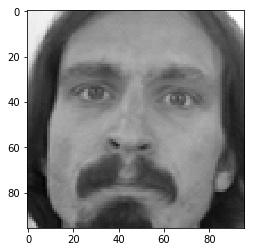

In [269]:
plt.imshow(np.reshape(a,[96,96]), cmap = 'gray')

Let's split the data into a separate NumPy array so there are separate image pixel data and label objects.

In [208]:
# this finction will take a data frame as an input and spit out two numpy arrays as a result:
# one ('labels') for the labels only (columns 0 to 29) for each of the features we are predicting, and
# another ('data') for the image pixel data corresponding to a 9216-long array of integer values between 0 and 255.
def trainDataLabelSplit(df):
    # assuming a dataframe input
    
    # create a DF of just the labels
    labels = np.array(df.iloc[:,:30])
    length = len(df)
#     length = 2

    data = np.empty(shape=(length,96,96,1))
    
    start = time.time()
    for i in range(length):
        data[i] = np.array(df.iloc[i,30].split()).reshape(96,96,1)
        if i % 500 == 0:
            print('%d: %.5f seconds elapsed.'%(i,time.time()-start))
    
    return labels, data.astype('int16')

In [209]:
start = time.time()
training_labels, training_data = trainDataLabelSplit(training)
end = time.time()
print('Total %9.5f seconds.' %(end-start))

0: 0.00877 seconds elapsed.
500: 2.02929 seconds elapsed.
1000: 4.25315 seconds elapsed.
1500: 6.23963 seconds elapsed.
2000: 8.23393 seconds elapsed.
2500: 10.19891 seconds elapsed.
3000: 12.19726 seconds elapsed.
3500: 14.18087 seconds elapsed.
4000: 16.22491 seconds elapsed.
4500: 18.17183 seconds elapsed.
5000: 20.14315 seconds elapsed.
5500: 22.11462 seconds elapsed.
6000: 24.19095 seconds elapsed.
6500: 26.16065 seconds elapsed.
7000: 28.23756 seconds elapsed.
Total  28.63456 seconds.


In [307]:
def load_test_set(df):
    length = len(df)

    data = np.empty(shape=(length,96,96,1))
    
    start = time.time()
    for i in range(length):
        data[i] = np.array(df.iloc[i,1].split()).reshape(96,96,1)
        if i % 500 == 0:
            print('%d: %.5f seconds elapsed.'%(i,time.time()-start))
    
    return data.astype('int16')

In [308]:
start = time.time()
test_data = load_test_set(test)
end = time.time()
print('Total %9.5f seconds.' %(end-start))

0: 0.01993 seconds elapsed.
500: 2.13336 seconds elapsed.
1000: 4.16583 seconds elapsed.
1500: 6.17678 seconds elapsed.
Total   7.33789 seconds.


In [ ]:
def show_image_labels(img, labels):
    for i in range(0, len(labels), 2):
        if ~np.isnan(labels[i+1]) and ~np.isnan(labels[i]):
            img[int(labels[i+1]),int(labels[i]),:] = 255
    plt.imshow(img[:,:,0], cmap='viridis')

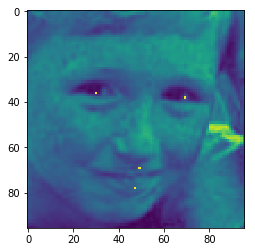

In [301]:
n = 5555
show_image_labels(training_data[n], training_labels[n])

Let's take a closer look at some of the data.

### Potentially interesting to look at:
* distribution of the pixel values (where do we see concentrations?)
* distribution of the feature values

### Pixel Value Distributions

To get an idea about our data set, we can see what the densities are like for the image set. This can be accomplished by summing all the pixel values and plotting these. The imshow() command will automatically scale these representing a density plot.

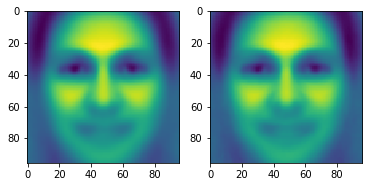

In [311]:
# To look at image densities, we "overlay" them by summing all the values at each pixel. 
# Higher values will show higher densities overall.

pixel_sums_train = np.zeros((96,96))
pixel_sums_test = np.zeros((96,96))

for r in range(96):
    for c in range(96):
        pixel_sums_train[r,c] = np.sum(training_data[:,r,c,0]/255)
        pixel_sums_test[r,c] = np.sum(test_data[:,r,c,0]/255)

plt.subplot(1,2,1)
plt.imshow(pixel_sums_train, cmap='viridis')
plt.subplot(1,2,2)
plt.imshow(pixel_sums_test, cmap='viridis')

This plot shows a few interesting points. The forehead, eyes, nose and cheeks are quite distinct, meaning that the majority of our images are centered in approximately the same location. The blurring above the lips and around the mouth area is likely due to mustaches, smiles vs frowns, etc. We can also see that our training and test sets generated similar images, so we should expect our model to perform relatively well to the test data set, though generalizability is something we'll need to look out for.

Based on this, one could assume that the a model may be more accurate with predictions of where the eyes and nose are, while having poorer accuracy with the mouth and potentially the ends of the eyebrows.

### Facial Keypoints Distributions

To take a deeper look at our dataset, we investigate where we our keypoints generally lie. This will help to identify any outlier images, and reinfornce the observations made in the previous step with the heatmaps.

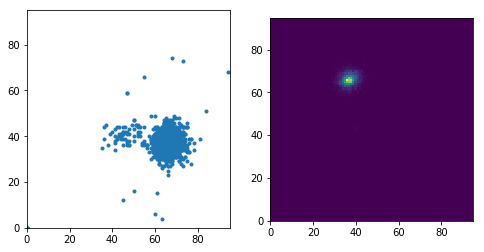

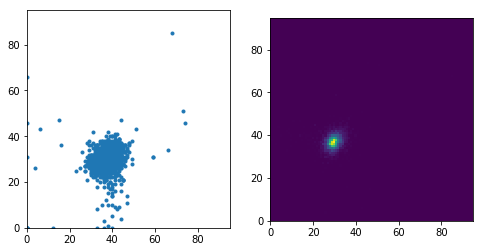

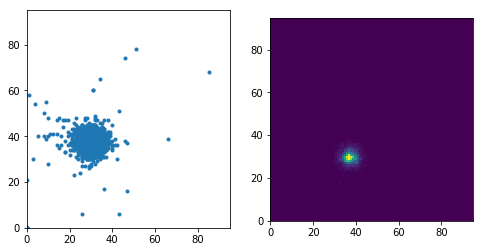

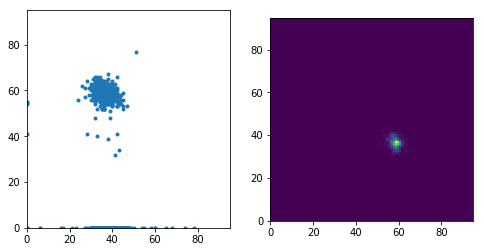

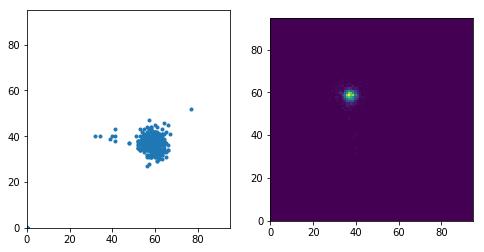

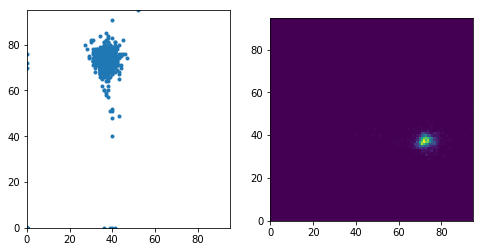

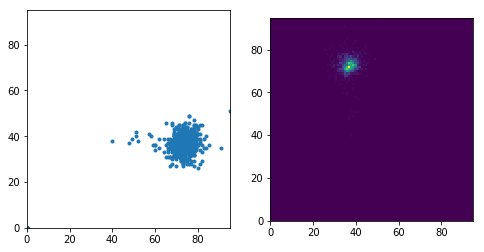

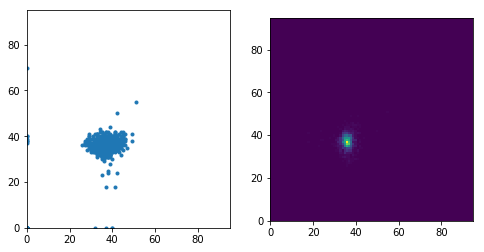

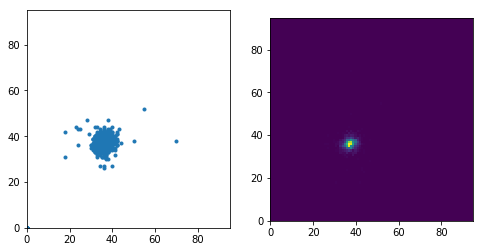

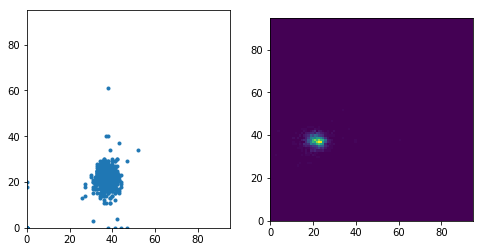

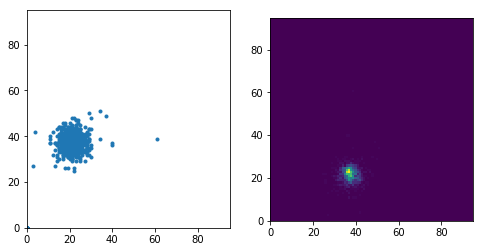

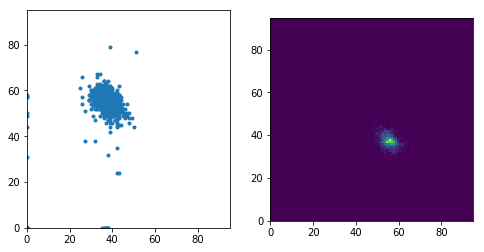

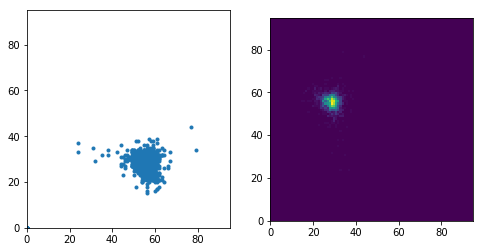

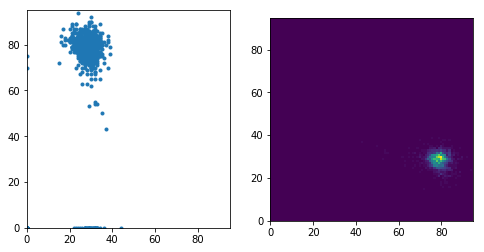

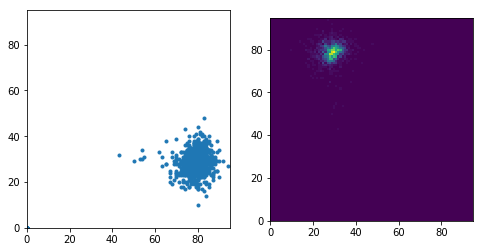

In [377]:
IMG_H = IMG_W = 96

def get_feature_density(feature_ind, label_array):
    feature_density = np.zeros((IMG_H, IMG_W))
    for i in range(len(label_array)):
        r = train_labels[i,feature_ind]
        c = train_labels[i,feature_ind+1]
        if ~np.isnan(r) and ~np.isnan(c):
            feature_density[int(r),int(c)] += 1
    return feature_density


for i in range(15):
    plt.figure(figsize=(8,4))
    ax1 = plt.subplot(1,2,1)
    ax1.scatter(x=train_labels[:,i].astype('int8'), y=train_labels[:,i+1].astype('int8'), marker='.')
    ax1.set_xlim(0,IMG_W-1)
    ax1.set_ylim(0,IMG_H-1)

    ax2 = plt.subplot(1,2,2)
    ax2.imshow(get_feature_density(i,train_labels), cmap='viridis')
    ax2.set_xlim(0,IMG_W-1)
    ax2.set_ylim(0,IMG_H-1)

    plt.show()

We can see that the features are generally clustered around a point, with few outliers. This aligns with the findings above where we saw the "average" image for our data set.

# Back to Modelling

In [228]:
train_data, dev_data, train_labels, dev_labels = train_test_split(
    training_data, training_labels, random_state = 1, test_size = 0.3)

In [262]:
# Build a model
model = Sequential()

# One CNN layer
model.add(Conv2D(64, kernel_size=5, input_shape=train_data[1].shape, data_format='channels_last'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten to representation to use with a Dense output layer
model.add(Flatten())

# add output layer for number of predictions desired
model.add(Dense(30))

# We want a linear activation so don't need to specify anything here.

In [263]:
# "Compile" the model
model.compile(optimizer = 'adam',loss = 'mean_squared_error', metrics = ['mae','acc'])

In [264]:
model.fit(train_data, train_labels, epochs=50)

Epoch 1/50
 352/4934 [=>............................] - ETA: 7:09 - loss: nan - mean_absolute_error: nan - acc: 0.0057

KeyboardInterrupt: 